# Mini-project n° 1 - Who painted this picture?

In [1]:
import PIL
from PIL import Image
import os, sys

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import optuna
from optuna.trial import TrialState

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import datasets, transforms, models
from tqdm import tqdm

from sklearn.model_selection import train_test_split

C:\Users\acer\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## Loading datas

In [3]:
data_path = "./art-challenge/"
if not os.path.isdir(data_path) or not os.listdir(data_path):
    !git clone https://plmlab.math.cnrs.fr/chevallier-teaching/datasets/art-challenge.git
else:
    print("Data already downloaded!")

Cloning into 'art-challenge'...
Updating files:   2% (465/16806)
Updating files:   3% (505/16806)
Updating files:   4% (673/16806)
Updating files:   5% (841/16806)
Updating files:   5% (1003/16806)
Updating files:   6% (1009/16806)
Updating files:   7% (1177/16806)
Updating files:   7% (1281/16806)
Updating files:   8% (1345/16806)
Updating files:   9% (1513/16806)
Updating files:  10% (1681/16806)
Updating files:  10% (1748/16806)
Updating files:  11% (1849/16806)
Updating files:  12% (2017/16806)
Updating files:  12% (2108/16806)
Updating files:  13% (2185/16806)
Updating files:  14% (2353/16806)
Updating files:  14% (2501/16806)
Updating files:  15% (2521/16806)
Updating files:  16% (2689/16806)
Updating files:  17% (2858/16806)
Updating files:  18% (3026/16806)
Updating files:  18% (3031/16806)
Updating files:  19% (3194/16806)
Updating files:  20% (3362/16806)
Updating files:  21% (3530/16806)
Updating files:  21% (3583/16806)
Updating files:  22% (3698/16806)
Updating files:  23%

In [4]:
# Reading CSV
artists = pd.read_csv(data_path + "artists.csv")
artists.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


## Analyse exploratoire du dataset

Nombre total d'artistes : 50
Nombre total de styles : 31


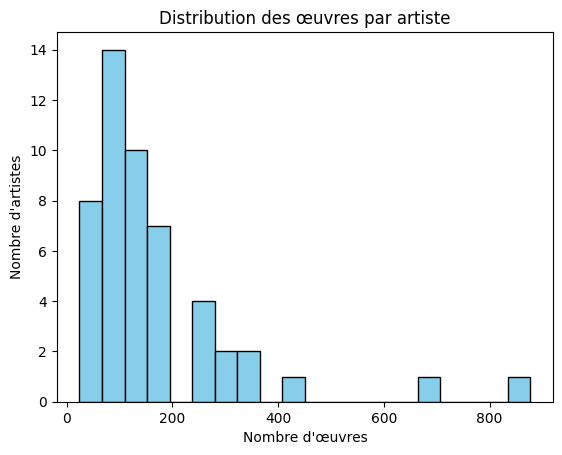

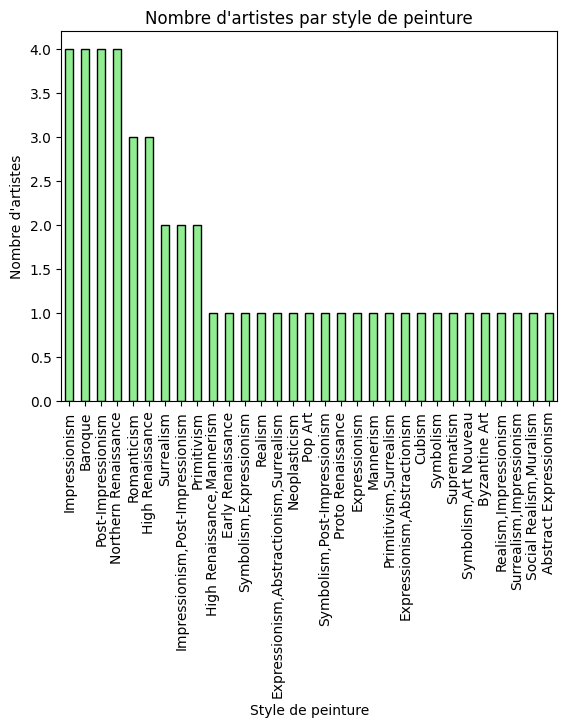

In [7]:
# Analyse descriptive des artistes et des styles
print("Nombre total d'artistes :", artists['name'].nunique())
print("Nombre total de styles :", artists['genre'].nunique())

# Distribution des œuvres par artiste
artists['paintings'].plot(kind='hist', bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution des œuvres par artiste")
plt.xlabel("Nombre d'œuvres")
plt.ylabel("Nombre d'artistes")
plt.show()

# Distribution des genres de peinture
style_counts = artists['genre'].value_counts()
style_counts.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title("Nombre d'artistes par style de peinture")
plt.xlabel("Style de peinture")
plt.ylabel("Nombre d'artistes")
plt.xticks(rotation=90)
plt.show()


In [10]:
# Artiste ayant le plus d'œuvres
artist_max = artists.loc[artists['paintings'].idxmax()]
print("Artiste avec le plus d'œuvres :")
print("Nom :", artist_max['name'])
print("Nombre d'œuvres :", artist_max['paintings'])
print("Genre :", artist_max['genre'])

# Artiste ayant le moins d'œuvres
artist_min = artists.loc[artists['paintings'].idxmin()]
print("\nArtiste avec le moins d'œuvres :")
print("Nom :", artist_min['name'])
print("Nombre d'œuvres :", artist_min['paintings'])
print("Genre :", artist_min['genre'])


Artiste avec le plus d'œuvres :
Nom : Vincent van Gogh
Nombre d'œuvres : 877
Genre : Post-Impressionism

Artiste avec le moins d'œuvres :
Nom : Jackson Pollock
Nombre d'œuvres : 24
Genre : Abstract Expressionism


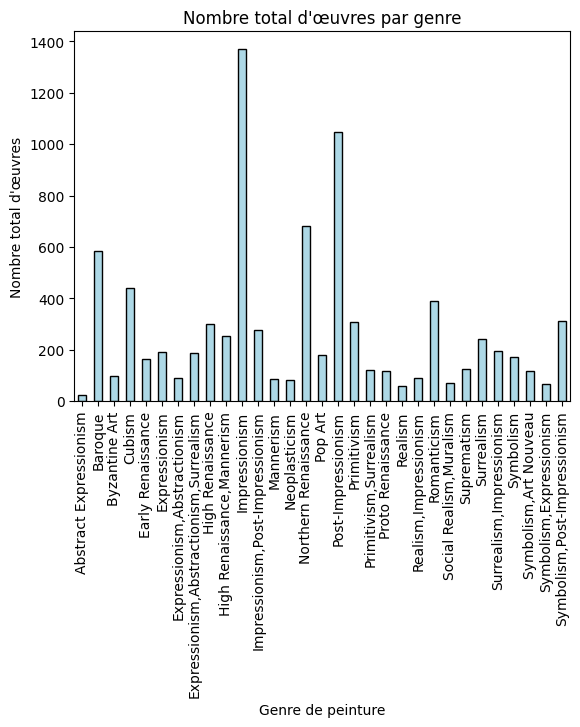

In [11]:
# Calcul du nombre total d'œuvres par genre
genre_paintings = artists.groupby('genre')['paintings'].sum()

# Création de l'histogramme
genre_paintings.plot(kind='bar', color='lightblue', edgecolor='black')
plt.title("Nombre total d'œuvres par genre")
plt.xlabel("Genre de peinture")
plt.ylabel("Nombre total d'œuvres")
plt.xticks(rotation=90)
plt.show()


On voit que la majorité des artistes ont un nombre d'oeuvre compris entre 100 et 200. Nous allons zoomer sur cette zone, de sorte à ce que nous puissions mieux observer les nombres d'oeuvres par artistes.
Néanmoins, on peut noter qu'un artiste  à plus de 800 oeuvres ( Vincent Van Gogh avec 877 oeuvres) et un artiste a 24 oeuvres (Jackson Pollock).
Cependant, en observant le nombre d'artiste par genre, on remarque que J. Pollock est le seul artiste dans sa catégorie, tandis que la catégorie de V. Van Gogh compte le plus d'artiste. De plus, en observant le nombre d'oeuvre par genre, on observe que le post impressionim compte beaucoup plus d'oeuvres que l'Expressionism.

Nombre total d'artistes : 50
Nombre total de styles : 31


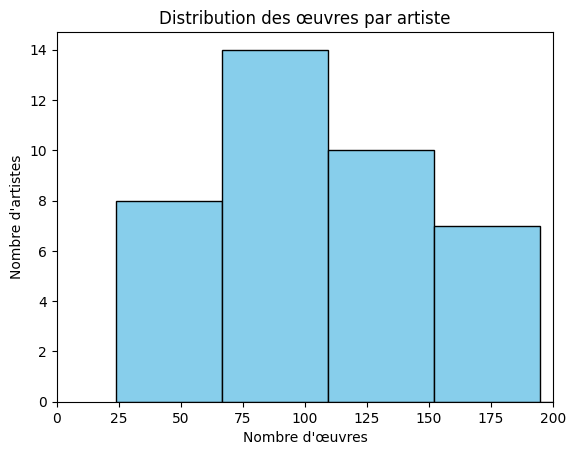

In [ ]:
# Analyse descriptive des artistes et des genre
print("Nombre total d'artistes :", artists['name'].nunique())
print("Nombre total de styles :", artists['genre'].nunique())

# Distribution des œuvres par artiste
artists['paintings'].plot(kind='hist', bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution des œuvres par artiste")
plt.xlabel("Nombre d'œuvres")
plt.ylabel("Nombre d'artistes")
plt.xlim(0, 200)  # Limite de l'axe x
plt.show()


maintenant que la distrbution des genre et des artistes est bien comprises, nous allons nous mener une analyse des périodes de vie des artistes; 

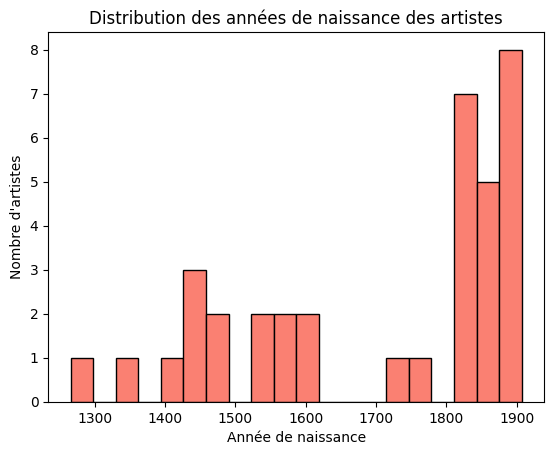

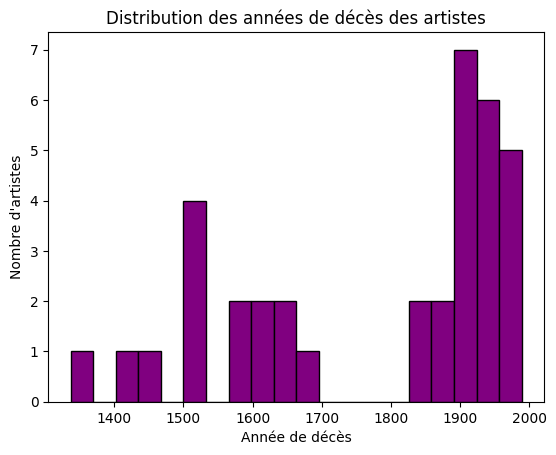

In [15]:
# On sépare la colonne 'year' en deux colonnes : 'birth_year' et 'death_year'
artists[['birth_year', 'death_year']] = artists['years'].str.split('-', expand=True)

# Conversion des nouvelles colonnes en format numérique
artists['birth_year'] = pd.to_numeric(artists['birth_year'], errors='coerce')
artists['death_year'] = pd.to_numeric(artists['death_year'], errors='coerce')

# Histogramme des années de naissance des artistes
artists['birth_year'].dropna().plot(kind='hist', bins=20, color='salmon', edgecolor='black')
plt.title("Distribution des années de naissance des artistes")
plt.xlabel("Année de naissance")
plt.ylabel("Nombre d'artistes")
plt.show()

# Histogramme des années de décès des artistes
artists['death_year'].dropna().plot(kind='hist', bins=20, color='purple', edgecolor='black')
plt.title("Distribution des années de décès des artistes")
plt.xlabel("Année de décès")
plt.ylabel("Nombre d'artistes")
plt.show()


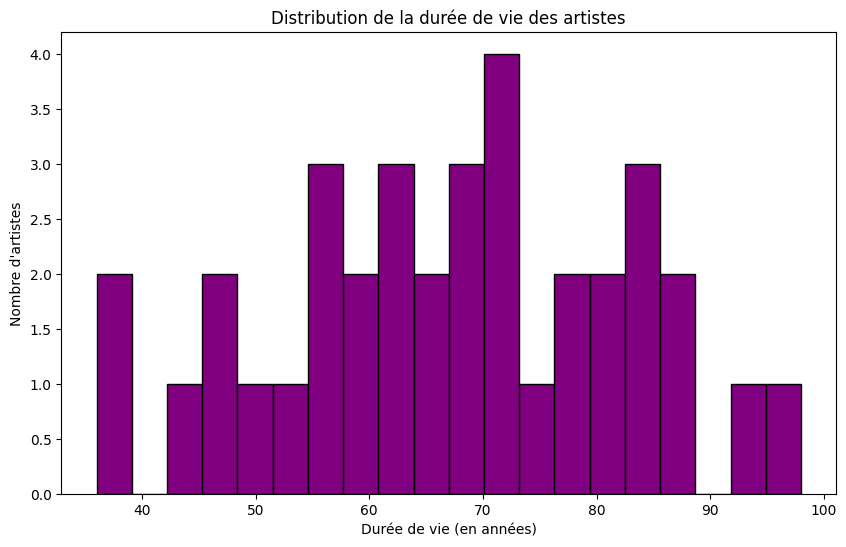

In [45]:
artists['birth_year'] = pd.to_numeric(artists['birth_year'], errors='coerce')
artists['death_year'] = pd.to_numeric(artists['death_year'], errors='coerce')

artists['life_duration'] = artists['death_year'] - artists['birth_year']
artists['life_duration'] = artists['life_duration'].dropna()

plt.figure(figsize=(10, 6))
artists['life_duration'].plot(kind='hist', bins=20, color='purple', edgecolor='black')
plt.title('Distribution de la durée de vie des artistes')
plt.xlabel('Durée de vie (en années)')
plt.ylabel('Nombre d\'artistes')
plt.show()


In [ ]:
# Calcul de la durée de vie des artistes
artists['birth_year'] = pd.to_numeric(artists['birth_year'], errors='coerce')
artists['death_year'] = pd.to_numeric(artists['death_year'], errors='coerce')
artists['life_duration'] = artists['death_year'] - artists['birth_year']

# Identification de l'artiste avec la plus grande durée de vie
longest_lived_artist = artists.loc[artists['life_duration'].idxmax()]
longest_lived_name = longest_lived_artist['name']
longest_lived_paintings = longest_lived_artist['paintings']
longest_lived_duration = longest_lived_artist['life_duration']

# Identification de l'artiste avec la durée de vie la plus courte
shortest_lived_artist = artists.loc[artists['life_duration'].idxmin()]
shortest_lived_name = shortest_lived_artist['name']
shortest_lived_paintings = shortest_lived_artist['paintings']
shortest_lived_duration = shortest_lived_artist['life_duration']

# Affichage des résultats
print(f"Artiste avec la plus grande durée de vie : {longest_lived_name} ({longest_lived_paintings} œuvres, {longest_lived_duration} ans)")
print(f"Artiste avec la durée de vie la plus courte : {shortest_lived_name} ({shortest_lived_paintings} œuvre(s), {shortest_lived_duration} ans)")


Artiste avec la plus grande durée de vie : Marc Chagall (239 œuvres, 98.0 ans)
Artiste avec la durée de vie la plus courte : Amedeo Modigliani (193 œuvre(s), 36.0 ans)


In [46]:
correlation = artists['life_duration'].corr(artists['paintings'])
print(f"Corrélation entre durée de vie et nombre d’œuvres : {correlation}")


Corrélation entre durée de vie et nombre d’œuvres : 0.33447442133662464


Nous observons que la majorité des artistes ont émergé à partir de 1800. 

Nombre d'artistes par nationalité :
nationality
French                      13
Italian                      8
Spanish                      5
Russian                      4
Dutch                        4
Flemish                      3
Mexican                      2
American                     2
Belgian                      1
Austrian                     1
Spanish,Greek                1
German                       1
French,British               1
French,Jewish,Belarusian     1
British                      1
Norwegian                    1
German,Swiss                 1
Name: count, dtype: int64


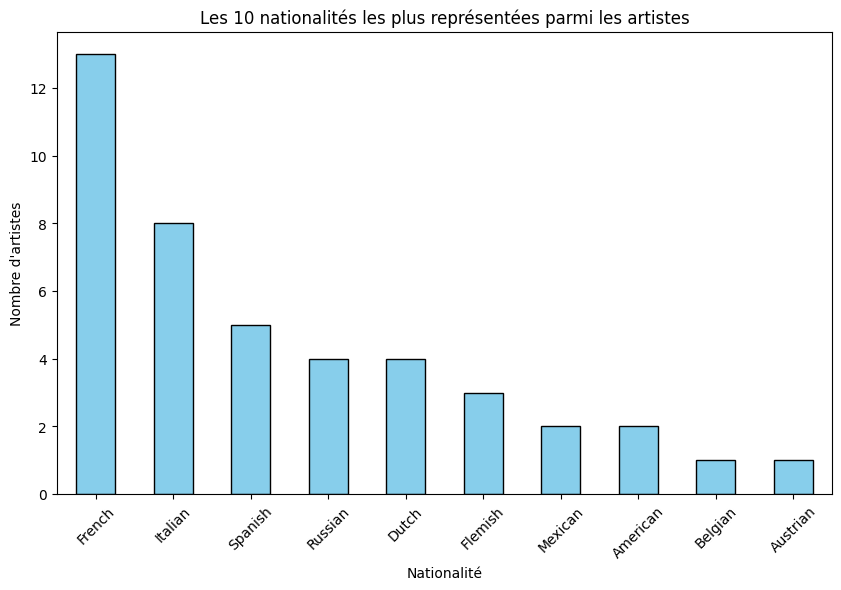

Nationalité la plus représentée : French (13 artistes)
Nationalité la moins représentée : Belgian (1 artiste(s))


In [43]:
import pandas as pd
import matplotlib.pyplot as plt



# 1. Distribution des nationalités
nationality_counts = artists['nationality'].value_counts()
print("Nombre d'artistes par nationalité :")
print(nationality_counts)

# 2. Visualisation des 10 nationalités les plus représentées
top_nationalities = nationality_counts.head(10)
plt.figure(figsize=(10, 6))
top_nationalities.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Les 10 nationalités les plus représentées parmi les artistes")
plt.xlabel("Nationalité")
plt.ylabel("Nombre d'artistes")
plt.xticks(rotation=45)
plt.show()

# 3. Nationalités les plus et les moins représentées
most_represented_nationality = nationality_counts.idxmax()
least_represented_nationality = nationality_counts.idxmin()

print(f"Nationalité la plus représentée : {most_represented_nationality} ({nationality_counts.max()} artistes)")
print(f"Nationalité la moins représentée : {least_represented_nationality} ({nationality_counts.min()} artiste(s))")


Nombre d'œuvres par pays :
nationality
French                      2120
Dutch                       1360
Spanish                     1099
Italian                     1087
Russian                      484
Flemish                      356
German                       328
French,British               259
French,Jewish,Belarusian     239
American                     205
Belgian                      194
Mexican                      190
German,Swiss                 188
Austrian                     117
Spanish,Greek                 87
Norwegian                     67
British                       66
Name: paintings, dtype: int64


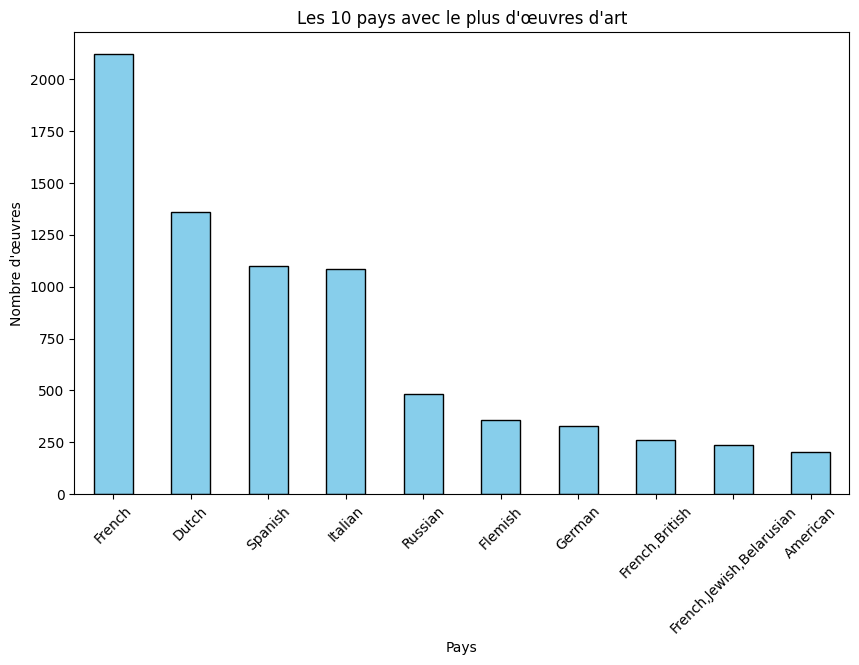

Pays avec le plus d'œuvres : French (2120 œuvres)
Pays avec le moins d'œuvres : British (66 œuvre(s))


In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Groupement par nationalité et somme des œuvres par pays
country_paintings = artists.groupby('nationality')['paintings'].sum().sort_values(ascending=False)

print("Nombre d'œuvres par pays :")
print(country_paintings)

# 2. Visualisation des 10 pays les plus représentés en termes d'œuvres
top_countries = country_paintings.head(10)
plt.figure(figsize=(10, 6))
top_countries.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Les 10 pays avec le plus d'œuvres d'art")
plt.xlabel("Pays")
plt.ylabel("Nombre d'œuvres")
plt.xticks(rotation=45)
plt.show()

# 3. Pays avec le plus et le moins d'œuvres
most_paintings_country = country_paintings.idxmax()
least_paintings_country = country_paintings.idxmin()

print(f"Pays avec le plus d'œuvres : {most_paintings_country} ({country_paintings.max()} œuvres)")
print(f"Pays avec le moins d'œuvres : {least_paintings_country} ({country_paintings.min()} œuvre(s))")


Nous observons que la majorité des artistes sont français ou italien, tandis que les artistes les moins nombeux sont orginaires de Belgique, d'Autriche, ...

En outre, nous observons que la France est le pays contenant le plus d'oeuvre, suivi de l'Allemagne. L'Italie arrive en 4ème position, alors qu'elle compte deux fois plus d'artistes que l'Allemagne (4 artistes). Cela nous montre qu'un nombre plus élevé d'artiste dans un pays n'implique pas forcément un plus grand nombre d'oeuvres produites par ces artistes.

## Global params

In [31]:
BATCH_SIZE = 32
EPOCHS = 6

## Creating LQ images loaders

In [32]:
# Loading LQ images
images_lq_path = data_path + "images_lq/"
images_filename = os.listdir(images_lq_path)

list_name = []

for filename in images_filename:
    parts = filename.split('_')
    if len(parts) > 2:
        name_surname = f"{parts[0]} {parts[1]}"
    elif len(parts) == 2:  # "Name_xxx" format
        name_surname = parts[0]  # Only Name
    list_name.append(name_surname)

In [33]:
if len(images_filename) == len(list_name):
    total_lq_df = pd.DataFrame({
        'filename': images_filename,  # Liste des noms de fichiers
        'artist': list_name,          # Liste des artistes pour chaque peinture
    })
    print("DataFrame created successfully!")
else:
    print("Error: The lists have different lengths.")

DataFrame created successfully!


In [34]:
# Prints df if previously created
total_lq_df.head()

,filename,artist
0,Albrecht_Dürer_1.jpg,Albrecht Dürer
1,Albrecht_Dürer_10.jpg,Albrecht Dürer
2,Albrecht_Dürer_100.jpg,Albrecht Dürer
3,Albrecht_Dürer_101.jpg,Albrecht Dürer
4,Albrecht_Dürer_102.jpg,Albrecht Dürer


In [35]:
IMAGE_LQ_SIZE = 64
DATASET_LQ_SIZE = len(images_filename)
CHANNELS = 3

def load_image_as_rgb_matrices(image_name):    
    img = Image.open(images_lq_path + image_name)
    img = img.resize((IMAGE_LQ_SIZE, IMAGE_LQ_SIZE))  
    img = img.convert('RGB')
    return np.array(img)

x = np.zeros((DATASET_LQ_SIZE, IMAGE_LQ_SIZE, IMAGE_LQ_SIZE, CHANNELS))
for i in range(DATASET_LQ_SIZE):
    x[i] = load_image_as_rgb_matrices(images_filename[i])

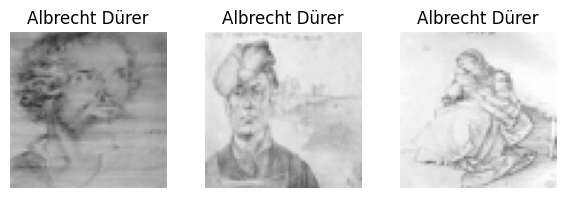

In [36]:
# Few plots
number_of_plots = 3
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(number_of_plots * 2, 2))

for i in range(number_of_plots):
    axes[i].imshow(x[i*100]/255.0)
    axes[i].axis('off')
    axes[i].set_title(f"{list_name[i*100]}")
    
plt.tight_layout()
plt.show()

In [37]:
# All the artists
classes = np.array(list(set(total_lq_df['artist'])))
classes_as_int = np.array([np.where(classes == artist)[0][0] for artist in total_lq_df['artist']])

x_train, x_test_val, y_train, y_test_val = train_test_split(
    np.transpose(x, (0, 3, 1, 2)),  classes_as_int, test_size=0.2, random_state=42
)

x_test, x_val, y_test, y_val = train_test_split(
    x_test_val, y_test_val, test_size=0.5, random_state=42
)

# Normalize images
x_train, x_val, x_test = x_train / 255.0, x_val / 255.0, x_test / 255.0

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset_lq = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset_lq = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset_lq = TensorDataset(x_test_tensor, y_test_tensor)

train_loader_lq = DataLoader(train_dataset_lq, batch_size=BATCH_SIZE, shuffle=True)
val_loader_lq = DataLoader(val_dataset_lq, batch_size=BATCH_SIZE, shuffle=True)
test_loader_lq = DataLoader(test_dataset_lq, batch_size=1, shuffle=False)

print(f"Train dataset size: {len(train_dataset_lq)}")
print(f"Validation dataset size: {len(val_dataset_lq)}")
print(f"Test dataset size: {len(test_dataset_lq)}")

Train dataset size: 6684
Validation dataset size: 836
Test dataset size: 835


## Creating HQ images loaders

In [38]:
# Loading HQ images
IMAGE_HQ_SIZE = 150

transform = transforms.Compose([
    transforms.Resize((IMAGE_HQ_SIZE, IMAGE_HQ_SIZE)),  # Resize to 150x150
    transforms.ToTensor(),  # Convert image to PyTorch tensor
])

gc = "./art-challenge/images_hq"
dataset_hq = datasets.ImageFolder(root=gc, transform=transform)
DATASET_HQ_SIZE = len(dataset_hq)
dataset_hq

Dataset ImageFolder
    Number of datapoints: 8446
    Root location: ./art-challenge/images_hq
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [39]:
train_size = int(0.8 * DATASET_HQ_SIZE)  # 70% pour l'entraînement
val_size = int(0.1 * DATASET_HQ_SIZE)   # 15% pour la validation
test_size = DATASET_HQ_SIZE - train_size - val_size  # Reste pour le test

train_dataset_hq, val_dataset_hq, test_dataset_hq = random_split(dataset_hq, [train_size, val_size, test_size])

train_loader_hq = DataLoader(train_dataset_hq, batch_size=BATCH_SIZE, shuffle=True)
val_loader_hq = DataLoader(val_dataset_hq, batch_size=BATCH_SIZE, shuffle=True)
test_loader_hq = DataLoader(test_dataset_hq, batch_size=1, shuffle=False)

print(f"Train dataset size: {len(train_dataset_hq)}")
print(f"Validation dataset size: {len(val_dataset_hq)}")
print(f"Test dataset size: {len(test_dataset_hq)}")

Train dataset size: 6756
Validation dataset size: 844
Test dataset size: 846


## Training Part

In [40]:
NUM_CLASSES = len(dataset_hq.classes) # Same value for lq dataset

def get_model(name='resnet152', pretrained=True, verbose=False):
    model = getattr(models, name)(pretrained=pretrained)
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

    if pretrained:
        # We don't train the conv layers
        for param in model.parameters():
            param.requires_grad = False  
        
        # Train the fully connected layer
        for param in model.fc.parameters():
            param.requires_grad = True 

    if verbose:
        trainable_params =  sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f'Trainable params: {trainable_params}')
        
    return model

In [41]:
# Here we use Optuna to optimize the best hyper-params
# Long time execution...
# See https://github.com/optuna/optuna-examples/blob/main/pytorch/pytorch_simple.py
def objective(trial):
    # Define the model
    model = get_model()
    model = model.to(DEVICE)

    # The different parameters we're trying to improve
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    # Loss
    criterion = nn.CrossEntropyLoss()
    
    # Training of the model
    for epoch in range(EPOCHS):
        model.train()
        for images, targets in train_loader_lq:
            images, targets = images.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        # Validation of the model
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, targets in val_loader_lq:
                images, targets = images.to(DEVICE), targets.to(DEVICE)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        accuracy = correct / total

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [42]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-11-12 21:42:44,920] A new study created in memory with name: no-name-1b8208af-d86c-488a-a97e-ae4d1f7a8652
C:\Users\acer\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\acer\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to C:\Users\acer/.cache\torch\hub\checkpoints\resnet152-394f9c45.pth
 45%|████▌     | 105M/230M [00:19<00:23, 5.68MB/s] 
[W 2024-11-12 21:43:06,3

KeyboardInterrupt: 